In [1]:
# Before starting import everything necessary
import numpy as np
import os
import simplejson as json
import sys
import torch
import torch_pruning as tp
import yaml

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from ssd.net import build_ssd

In [2]:
# Set presentation settings
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches

with open('../plots/palette.json') as json_file:
    color_palette = json.load(json_file)
plt.style.use('../plots/ssdjet.mplstyle')

In [3]:
# Pruning Globals

IN_CONFIG_NET = '../net-config.yml'
OUT_CONFIG_NET = '../net-config-last.yml'
MODEL_TO_PRUNE = '../models/PF-Jet-SSD-fp-Attention-MorphNet.pth'
#max_channels = [32, None, 64, 128, 128, None, 256, 512, 512, None, 512, 512, None, 1024, 1024]
max_channels = [32, None, 64, 128, 128, None, 230, 435, 435, None, 435, 435, None, 845, 845]
#max_channels = [32, None, 64, 128, 128, None, 205, 358, 358, None, 358, 358, None, 666, 666]
#max_channels = [32, None, 64, 128, 128, None, 179, 281, 281, None, 281, 281, None, 487, 487]
#max_channels = [32, None, 64, 128, 128, None, 153, 204, 204, None, 204, 204, None, 308, 308]
#max_channels = [32, None, 64, 128, 128, None, 128, 128, 128, None, 128, 128, None, 128, 128] 

In [4]:
# Load the original network

CONFIG_FILE = '../ssd-config.yml'
config = yaml.safe_load(open(CONFIG_FILE))
config_net = yaml.safe_load(open(IN_CONFIG_NET))
ssd_settings = config['ssd_settings']
ssd_settings['n_classes'] += 1
channels = config_net['network_channels']

net = build_ssd("cpu", config['ssd_settings'], channels)
net.load_weights(MODEL_TO_PRUNE)
net.eval();
print(channels)

[32, 64, 128, 128, 256, 512, 512, 512, 512, 1024, 1024]


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


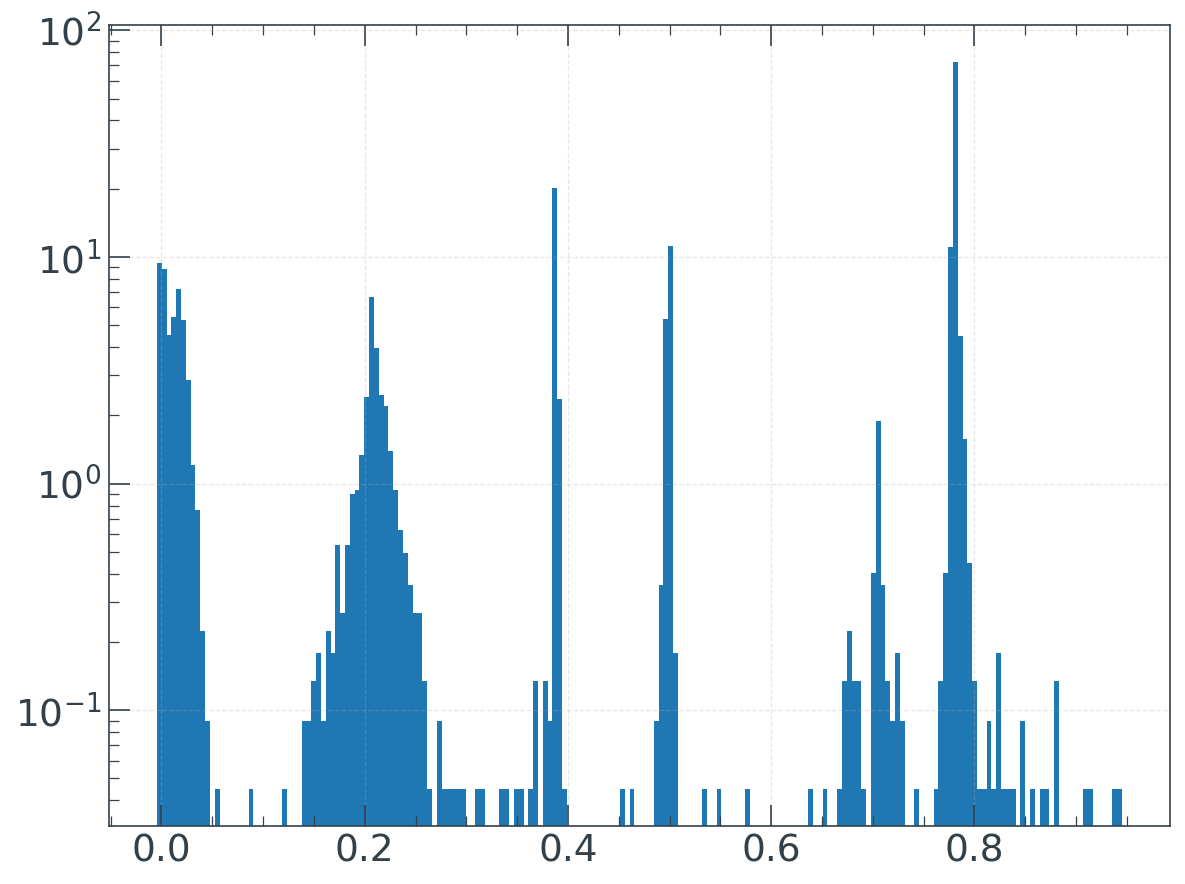

In [5]:
# Plot new batch norm distribution
def get_gamma_distribution(net):
    gammas = np.array([])
    for name, param in net.named_parameters():
        if '.4.weight' in name or 'mobilenet.0.1.weight' in name:
            gammas = np.append(gammas, param.detach().cpu().numpy())
    return gammas

gammas = get_gamma_distribution(net)
fig, ax = plt.subplots(tight_layout=True)
ax.hist(gammas, bins=200, density=True)
ax.set_yscale('log')

In [6]:
# Prune the model (Dry run)

import torch.nn as nn

def is_pooling_layer(layer):
    """
    Checks if layer is a pooling layer.
    """
    return isinstance(layer, nn.AvgPool2d)

for x, (child, mc) in enumerate(zip(net.mobilenet.children(), max_channels)):

    if not is_pooling_layer(child):
        
        if len(child) == 4:
            conv_dw = False
            _, gamma = list(child.named_parameters())[1]
            th1 = torch.mean(torch.abs(gamma))-torch.std(torch.abs(gamma))

        if len(child) == 6:
            conv_dw = True
            _, gamma = list(child.named_parameters())[-3]
            th1 = torch.mean(torch.abs(gamma))-torch.std(torch.abs(gamma))

        th2 = sorted(gamma)[mc-1]
        THRESHOLD = max(th1, th2)
        target_channels = sum(gamma < THRESHOLD)
        print("Module {} pruned by {}%".format(x, 100 - 100*target_channels/len(gamma)))

Module 0 pruned by 3.125%
Module 2 pruned by 1.5625%
Module 3 pruned by 0.78125%
Module 4 pruned by 0.78125%
Module 6 pruned by 10.546875%
Module 7 pruned by 15.234375%
Module 8 pruned by 15.234375%
Module 10 pruned by 15.234375%
Module 11 pruned by 15.234375%
Module 13 pruned by 17.578125%
Module 14 pruned by 17.578125%


In [7]:
# Prune the model (Real)

DG = tp.DependencyGraph()
DG.build_dependency(net, example_inputs=torch.randn(1,3,340,360))

for x, (child, mc) in enumerate(zip(net.mobilenet.children(), max_channels)):

    if not is_pooling_layer(child):

        if len(child) == 4:
            conv_dw = False
            name, gamma = list(child.named_parameters())[1]
            th1 = torch.mean(torch.abs(gamma))-torch.std(torch.abs(gamma))
            th2 = sorted(gamma)[-mc]
            THRESHOLD = max(th1, th2)
            pruning_idxs = (gamma < THRESHOLD).nonzero().reshape(-1).tolist()
            if len(pruning_idxs):
                pruning_plan = DG.get_pruning_plan(net.mobilenet[x][1], tp.prune_batchnorm, idxs=pruning_idxs)
                pruning_plan.exec()

        if len(child) == 6:
            conv_dw = True
            name, gamma = list(child.named_parameters())[-3]
            th1 = torch.mean(torch.abs(gamma))-torch.std(torch.abs(gamma))
            th2 = sorted(gamma)[-mc]
            THRESHOLD = max(th1, th2)
            pruning_idxs = (gamma < THRESHOLD).nonzero().reshape(-1).tolist()
            if len(pruning_idxs):
                pruning_plan = DG.get_pruning_plan(net.mobilenet[x][-2], tp.prune_batchnorm, idxs=pruning_idxs)
                pruning_plan.exec()

In [8]:
# Export new channel config
ch = []
for x, child in enumerate(net.mobilenet.children()):
    if not is_pooling_layer(child):
        if len(child) == 4:
            ch.append(child[0].out_channels)
        if len(child) == 6:
            ch.append(child[-3].out_channels)

with open(OUT_CONFIG_NET, 'w') as f:
    yaml.dump({"network_channels": ch}, f)
    
print(ch)

[31, 63, 125, 125, 230, 383, 368, 435, 435, 845, 845]


In [9]:
# Save the new model
torch.save(net.state_dict(), MODEL_TO_PRUNE)

In [10]:
net

SSD(
  (mobilenet): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 31, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(31, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): DropBlock2D()
      (3): PReLU(num_parameters=31)
    )
    (1): AvgPool2d(kernel_size=2, stride=2, padding=1)
    (2): Sequential(
      (0): Conv2d(31, 31, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=31, bias=False)
      (1): BatchNorm2d(31, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): PReLU(num_parameters=31)
      (3): Conv2d(31, 63, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (4): BatchNorm2d(63, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): PReLU(num_parameters=63)
    )
    (3): Sequential(
      (0): Conv2d(63, 63, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=63, bias=False)
      (1): BatchNorm2d(63, eps=1e-05, momentum=0.1, affine=True, track_